# Instalando as libs do kaggle e minisom

In [1]:
!pip install minisom 
!pip install scikit-learn
!pip install --upgrade kaggle

  Created wheel for minisom: filename=MiniSom-2.2.8-cp37-none-any.whl size=8604 sha256=41e6cf01e44dc8936d131a1538e8c0ee0c8a1f050e487cb9d24cf33fcd920efa
  Stored in directory: /root/.cache/pip/wheels/78/7e/a8/435947263149d3b94fa65339751f8c65617c436b0bdfb29c7d
Successfully built minisom
     |████████████████████████████████| 61kB 6.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=2addc46704e609e5d15c2464721b2ad0b6f5ee30bbee014344f64b0611419c88
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


# upload da chave da API




In [2]:
#OBS: o arquivo kaggle.json precisa ser baixado da sua conta pessoal do Kaggle.
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn]))
    )

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


# Movendo arquivo da API para pasta de configuração

- Ele deve ficar na pasta ```~/.kaggle```
- Depois disso mudar as permissões para "leitura e escrita" (2 + 4 = 6)

> Bloco com recuo



In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Download do dataset


In [4]:
#!kaggle datasets download -d /spotify-dataset-yamaerenay19212020-160k-tracks
#!unzip spotify-dataset-19212020-160k-tracks.zip -d destination_folder
!kaggle datasets download -d teejmahal20/airline-passenger-satisfaction
!unzip airline-passenger-satisfaction.zip -d destination_folder

  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 186MB/s]
Archive:  airline-passenger-satisfaction.zip
  inflating: destination_folder/test.csv  
  inflating: destination_folder/train.csv  


In [5]:
!ls destination_folder

test.csv  train.csv


In [6]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from minisom import MiniSom
import scipy.cluster.hierarchy as shc       # para usar o dendrograma
%matplotlib inline

In [7]:
data = pd.read_csv(r'destination_folder/train.csv')
data_test = pd.read_csv(r'destination_folder/test.csv')
data = pd.concat([data, data_test])         # concatenar os dois conjuntos, já que é um problema de clustering
data = data.drop(['Unnamed: 0', 'id'], axis=1)   # retirar as colunas de informações irrelevantes ao problema

#data = data.drop(['artists', 'id', 'name', 'mode', 'explicit', 'release_date', 'year', 'key'], 1)
#data = data.astype({'duration_ms': 'float64', 'popularity': 'float64'}, copy=False)
data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [8]:
data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


# Pré-processando os dados categóricos

In [9]:
# separando as colunas que passarao por tratamentos especiais
nominal_data = data[['Gender', 'Customer Type', 'Type of Travel', 'satisfaction']]
ordinal_data = data['Class']    # Eco < Eco Plus < Business (em termos de relevância ou preço)

# removendo as colunas que na sequência passarão pelo encoding
data = data.drop(columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'])

In [10]:
# tratando os dados ordinais: ['Class']
class_labels = ['Eco', 'Eco Plus', 'Business']
ordinal_data = ordinal_data.astype(CategoricalDtype(categories=class_labels, ordered=True))
ordinal_data = ordinal_data.cat.codes
data['Class'] = ordinal_data

In [11]:
# tratando os dados nominais: ['Gender', 'Customer Type', 'Type of Travel', 'satisfaction']
for column in nominal_data:
    encoded_data = pd.get_dummies(nominal_data[column])
    data = pd.concat([data, encoded_data], axis=1)

In [12]:
data.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Class,Female,Male,Loyal Customer,disloyal Customer,Business travel,Personal Travel,neutral or dissatisfied,satisfied
0,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,1,0,1,1,0,0,1,1,0
1,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,2,0,1,0,1,1,0,1,0
2,26,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,2,1,0,1,0,1,0,0,1
3,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,2,1,0,1,0,1,0,1,0
4,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,2,0,1,1,0,1,0,0,1


# Normalizando os dados

In [13]:
# removendo as linhas que contêm NaN
# como são poucas, não é inviável
data = data.dropna()

In [14]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data) # normaliza/escala e converte para array numpy que é o que o MiniSom() aceita
num_features = data.shape[1]    # numero de colunas/features

# Treinando o modelo

In [19]:
som = MiniSom(x=10, 
                 y=10,
                 input_len=num_features, 
                 sigma=1.0,
                 learning_rate=0.5, 
                 neighborhood_function='gaussian', 
                 activation_distance='euclidean')
som.pca_weights_init(data)
som.train_random(data, 200000, verbose=True)

/usr/local/lib/python3.7/dist-packages/minisom.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


 [ 200000 / 200000 ] 100% - 0:00:00 left 
 quantization error: 0.7506538033504361


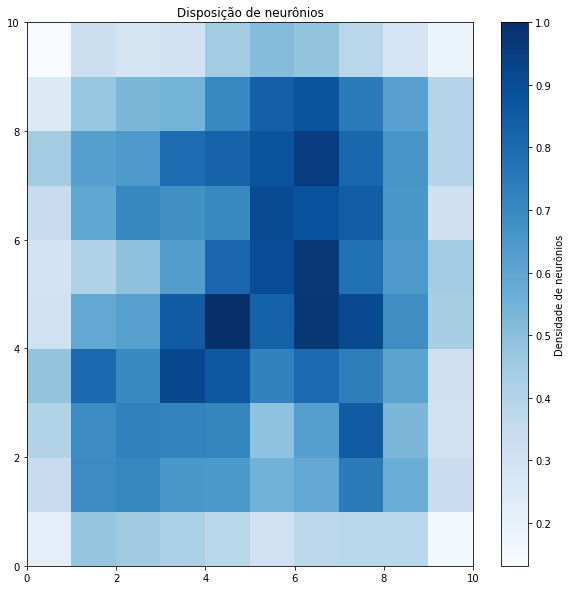

In [20]:
plt.figure(1, figsize=(10, 10), frameon=False)
plt.bone()

plt.title('Disposição de neurônios')
plt.pcolor(som.distance_map(), cmap='Blues')# average dist. to neighs.
plt.colorbar(label='Densidade de neurônios')

In [23]:
# dimensões do grid/camada de Kohonen
som.get_weights().shape

(10, 10, 27)

# Visualização dos resultados

In [ ]:
# OBS: FORMA ANTIGA DE VISUALIZAÇÃO (PRECISA REVER)

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, dims=(10, 10))

In [ ]:
# OBS: FORMA ANTIGA DE VISUALIZAÇÃO (PRECISA REVER)

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();